In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import heapq 
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import dateutil
import datetime 
from time import time
import re
from scipy import interpolate
import timeit
from dateutil.rrule import DAILY, rrule, MO, TU, WE, TH, FR
import seaborn as sns
from sklearn.mixture import GaussianMixture
from neupy import algorithms
from sklearn.metrics import mean_squared_error
import itertools
from scipy import linalg

import sys
sys.path.append("../")

from historical.readData.old.estimateData3 import read

from historical.readData.old.estimateData3 import read
from historical.readData.old.estimateData3 import search_travels
from historical.readData.old.estimateData3 import estimate
from historical.readData.old.estimateData3 import stops_distance

from historical.readData.old.travels3 import haversine2

def calcula_dist_shape(selec_linhas):
    distance_all_shapes = {}
    # print 'Calculando distancias dos shapes'
    '''calcula todas as distancias dos shapes'''
    
    pth_files_GTFS = "../historical/readData/dados/gtfs/"        
        
    trips = pd.read_csv(pth_files_GTFS + 'trips.txt', sep=',')
    shapes = pd.read_csv(pth_files_GTFS + 'shapes.txt', sep=',')
    
    for l, trip_id in enumerate(selec_linhas):

        trip = trips[trips.trip_id == trip_id]
        trip_shape = shapes[shapes['shape_id'].isin(trip['shape_id'])]
        shapelat = trip_shape.shape_pt_lat.tolist()
        shapelon = trip_shape.shape_pt_lon.tolist()

        # distancias dos shapes
        lon1 = shapelon[0]
        lat1 = shapelat[0]
        totalcal = [0.]
        dist = [0.]
        for lat2, lon2 in zip(shapelat[1:], shapelon[1:]):
            d = haversine2(lat1, lon1, lat2, lon2)
            d = d * 1000
            dist.append(d)
            totalcal.append(totalcal[-1] + d)
            lat1 = lat2
            lon1 = lon2
        distance_all_shapes[trip_id] = [shapelat, shapelon, totalcal]
    return distance_all_shapes

def stops_distance(linha):

    distances = calcula_dist_shape([linha])
    totalcal = distances[linha][2]
    
    pth_files_GTFS = "../historical/readData/dados/gtfs/"
    

    trips = pd.read_csv(pth_files_GTFS + 'trips.txt', sep=',')
    shapes = pd.read_csv(pth_files_GTFS + 'shapes.txt', sep=',')
    stops = pd.read_csv(pth_files_GTFS + 'stops.txt', sep=',')
    stopid = pd.read_csv(pth_files_GTFS + 'stop_times.txt', sep=',')   

    ida = trips[trips.trip_id == linha]
    shapeida = shapes[shapes['shape_id'].isin(ida['shape_id'])]
    idalat = shapeida.shape_pt_lat.tolist()
    idalon = shapeida.shape_pt_lon.tolist()
    total = shapeida.shape_dist_traveled.tolist()

    temp1 = stopid[stopid.trip_id == linha]
    stopsida = stops[stops['stop_id'].isin(temp1['stop_id'])]
    stopsida = stopsida.set_index('stop_id')
    stopsida = stopsida.reindex(index=temp1['stop_id'])

    stopslat = stopsida.stop_lat.tolist()
    stopslon = stopsida.stop_lon.tolist()

    dpontos = [None] * len(stopslat)
    index = 0
    lat = idalat
    lon = idalon
    total = 0
    p = ['depois'] * len(stopslat)
    for latb, lonb, i in zip(stopslat, stopslon, range(len(stopslat))):
        lat = lat[index:]
        lon = lon[index:]
        nn = haversine2(latb, lonb, np.array(lat), np.array(lon)) * 1000
        index = nn.argmin()
        total = total + index
        if index == 0:
            dpontos[i] = nn[index]
#            descontardist = nn[index]
        else:
            if totalcal[total] >= totalcal[total - 1] + nn[index - 1]:
                p[i] = 'antes'
            dpontos[i] = totalcal[total - 1] + nn[index - 1]

    mid_points = []
#    mid_points.append(200)
    p1 = dpontos[0]
    for p2 in dpontos[1:]:
        mid_points.append(p1 + (p2-p1)/2)
        p1 = p2
    dpontos = [i/1000. for i in dpontos]
    mid_points = [i/1000. for i in mid_points]
    # dpontos = [val-descontardist for val in dpontos]
    # stopsida.reset_index(drop=True, inplace=True)
    # stopsida['distancia'] = dpontos
    # stopsida.sort_values('distancia',axis=0,inplace=True)
    # stopsida.reset_index(drop=True, inplace=True)

    # gmap = gmplot.GoogleMapPlotter(idalat[0], idalon[0], 19)
    # gmap.marker(idalat[0],idalon[0], title='Test text')
    # gmap.plot(idalat, idalon, 'blue')
    # gmap.scatter(idalat, idalon, c='blue', size=10, marker=True, titles=totalcal)
    # gmap.scatter(stopsida['stop_lat'].tolist(), stopsida['stop_lon'].tolist(), c='red', size=10, marker=True,
    #             titles=["Ponto " + str(i + 1) + ": dist: " + str(stopsida['distancia'][i]) + ' ' + p[i] for i in
    #                     range(len(dpontos))])

    # gmap.draw('pontos.html')

    return dpontos, mid_points

def read(filedata,filerep):
    df0 = pd.read_pickle(filedata, compression=None)
    with open(filerep, 'rb') as handle:
        reps = pickle.load(handle, encoding='latin1')
    return df0, reps

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + datetime.timedelta(n)
        
def daterangeWD(start_date, end_date):
  return rrule(DAILY, dtstart=start_date, until=end_date, byweekday=(MO,TU,WE,TH,FR))

def hr_func(ts):
    return ts.hour

def minute_func(ts):
    return ts.minute

def second_func(ts):
    return ts.second

In [4]:

# if __name__ == '__main__':

selected_line = ['8700-10-1']

# '8700-10-0',
# selected_line = ['8700-10-1',                
#                 '7545-10-1',
#                 '7545-10-0',
#                 '6450-10-1',
#                 '6450-10-0',
#                 '3301-10-1',
# #                 '3301-10-0',
#                 '2290-10-1',
#                 '2290-10-0',
# #                 '574J-10-1',
# #                 '574J-10-0',
# #                 '477P-10-1',
#                 '477P-10-0',
# #                 '351F-10-1',
# #                 '351F-10-0'
#                 ]

pth_files_GTFS = "../historical/readData/dados/gtfs/"

trips = pd.read_csv(pth_files_GTFS + 'trips.txt', sep=',')
shapes = pd.read_csv(pth_files_GTFS + 'shapes.txt', sep=',')
stops = pd.read_csv(pth_files_GTFS + 'stops.txt', sep=',')
stopid = pd.read_csv(pth_files_GTFS + 'stop_times.txt', sep=',')   

periods = ['morning', 'm_peak', 'i_peak', 'a_peak', 'night']

line = selected_line[0]
p, mp = stops_distance(line)
pth_files_lines = "../historical/readData/"

### Operação demorada
df, reps = read(pth_files_lines + "trips_" + line + ".dsk", pth_files_lines + "interps_" + line + ".rep")


In [5]:
df['day'] = pd.to_datetime(df['day'], format = '%Y-%m-%d')
df['start'] = pd.to_datetime(df['start'], format = '%H:%M:%S')

df['exact_time'] = df['day'] + \
                       pd.to_timedelta(pd.DatetimeIndex(df['start']).hour*60 + \
                       pd.DatetimeIndex(df['start']).minute + \
                       pd.DatetimeIndex(df['start']).second/60 + \
                       df['time'], unit='m')

df['link'] = 0
for i in range(0, len(mp)):
    if (i == 0):
          df.loc[df.loc[(df['distance'] > 0) & (df['distance'] < mp[i+1]),]['link'].index,'link'] = i    
    if (i == len(mp) -1):
        df.loc[df.loc[(df['distance'] > mp[i]) & (df['distance'] < max(p)),]['link'].index,'link'] = i    
    if (i != 0) & (i != len(mp)-1):
        df.loc[df.loc[(df['distance'] >= mp[i]) & (df['distance'] < mp[i+1]),]['link'].index,'link'] = i  
        
df = df.drop_duplicates(subset=['numtravel', 'link'])        

link_df = []

travels = sorted(list(set(df.numtravel.unique())))
for tr in travels:
    tck = reps[tr][0]
    tck_mods = [(tck[0],tck[1]-m,tck[2]) for m in mp]       
    tempo = [a[0] if a.size>0 else np.nan for a in [interpolate.sproot(tck_mod) for tck_mod in tck_mods]]
    row = [tuple([tempo[i+1]-pos for i, pos in enumerate(tempo[:-1])])]    
    link_df.append(row)
    
    
# data_training['time_link'] = 0 
link_df_np = np.array(link_df)
link_df_np.shape = (np.shape(link_df_np)[0] * np.shape(link_df_np)[2])

# df['time_link'] = 0

right = pd.DataFrame({'numtravel': np.repeat(df.numtravel.unique(), len(mp)-1), \
              'link': np.tile(range(0, len(mp)-1), len(df.numtravel.unique())), 
              'time_link': link_df_np}) 

df = pd.merge(right, df, how='right', on=['numtravel', 'link'])

df.loc[(df['time_link'] > 5),'time_link'] = np.ceil(df['time_link'].mean())
df = df.loc[((df['link'] > 0) & (df['link'] < len(mp)-2))]      

start_date = pd.to_datetime('2017-1-1', format = '%Y-%m-%d')
end_date = pd.to_datetime('2017-8-1', format = '%Y-%m-%d')

df.index = df['exact_time']

df_training = df.loc[(df['day'] < end_date) & (df['holiday'] != 1) & ((df['weekday'] > 0) & (df['weekday'] < 6))]

temp = df_training.groupby([pd.Grouper(freq='30min'), 'link'], as_index=True ).mean().reset_index()['exact_time'].apply(hr_func)*60 +\
        df_training.groupby([pd.Grouper(freq='30min'), 'link'], as_index=True ).mean().reset_index()['exact_time'].apply(minute_func)*60

X_Train = df_training.groupby([pd.Grouper(freq='30min'), 'link'], as_index=True ).mean()['time_link'].unstack()\
    .rolling(2).mean().transform(lambda x: x.fillna(method='ffill')).dropna().unstack().reset_index()

X_Train.columns = ['link', 'exact_time','time_link_mean']

right = df_training.groupby([pd.Grouper(freq='30min'), 'link'], as_index=True ).std()['time_link'].unstack()\
    .rolling(2).mean().transform(lambda x: x.fillna(method='ffill')).dropna().unstack().reset_index()

right.columns = ['link', 'exact_time','time_link_std']

X_Train = pd.merge(right, X_Train, how='left', on=['exact_time', 'link'])
X_Train['day_minute'] = pd.DatetimeIndex(X_Train['exact_time']).hour*60 + pd.DatetimeIndex(X_Train['exact_time']).minute


df_test = df.loc[(df['day'] >= end_date) & (df['holiday'] != 1) & ((df['weekday'] > 0) & (df['weekday'] < 6))]

temp = df_test.groupby([pd.Grouper(freq='30min'), 'link'], as_index=True ).mean().reset_index()['exact_time'].apply(hr_func)*60 +\
        df_test.groupby([pd.Grouper(freq='30min'), 'link'], as_index=True ).mean().reset_index()['exact_time'].apply(minute_func)*60

X_Test = df_test.groupby([pd.Grouper(freq='30min'), 'link'], as_index=True ).mean()['time_link'].unstack()\
    .rolling(2).mean().transform(lambda x: x.fillna(method='ffill')).dropna().unstack().reset_index()

X_Test.columns = ['link', 'exact_time','time_link_mean']

right = df_test.groupby([pd.Grouper(freq='30min'), 'link'], as_index=True ).std()['time_link'].unstack()\
    .rolling(2).mean().transform(lambda x: x.fillna(method='ffill')).dropna().unstack().reset_index()

right.columns = ['link', 'exact_time','time_link_std']

X_Test = pd.merge(right, X_Test, how='left', on=['exact_time', 'link'])
X_Test['day_minute'] = pd.DatetimeIndex(X_Test['exact_time']).hour*60 + pd.DatetimeIndex(X_Test['exact_time']).minute

del(df, reps, df_training, df_test, right)

/home/marcos/tensorflow/lib/python3.5/site-packages/scipy/interpolate/_fitpack_impl.py:731: RuntimeWarning: The number of zeros exceeds mest
  warnings.warn(RuntimeWarning("The number of zeros exceeds mest"))


In [17]:

n_samples = 4500
for link in range(1,len(mp)-2):

    y_train = X_Train.loc[X_Train.link != link,:  ][['time_link_mean']]
    x_train = X_Train.loc[X_Train.link != link,:  ][['link', 'time_link_std', 'day_minute']]             

    x_test = X_Test.loc[X_Test.link == link,:  ][['link', 'time_link_std', 'day_minute']]             
    y_test = X_Test.loc[X_Test.link == link,:  ][['time_link_mean']]

    model_grnn = algorithms.GRNN(std=0.1, verbose=False)
    model_grnn.fit(x_train, y_train)
    y_predicted = model_grnn.predict(x_test[:n_samples])

    error = mean_squared_error(y_test[:n_samples], y_predicted)
    accuracy = y_test[:n_samples].values/y_predicted

    Q1 = np.quantile(accuracy, 0.25)
    Q3 = np.quantile(accuracy, 0.75)
    IQR = Q3 - Q1
    outliers = ((accuracy < (Q1 - 1.5 * IQR)) | (accuracy > (Q3 + 1.5 * IQR))).sum()
    print('Target: MEAN ' + str(link) + ' | Samples: ' + str(n_samples) + '. MSE: %.5f' % error + ' outliers: ' + str(outliers))

    fig, (ax, ax2, ax1, ax3) = plt.subplots(ncols=4, constrained_layout=True, figsize=(16,4))

    ax.boxplot(accuracy, showmeans=True)
    ax.set_title('MEAN | Measured/Predicted')
    if outliers != 0:
        ax.text(.55, Q3 + 1.5 * IQR, "Outliers="+str(outliers), size=12, color='blue')
    ax.text(.55, np.mean(accuracy), "MSE="+str('%.3f' % error), size=12, color='red')
    ax.text(1.1, np.max(accuracy), "Max="+str('%.3f' % np.max(accuracy)), size=12, color='blue')
    ax.text(1.1, np.min(accuracy), "Min="+str('%.3f' % np.min(accuracy)), size=12, color='blue')
    ax.text(1.1, Q1, "Q1="+str('%.3f' %  Q1), size=12, color='blue')
    ax.text(1.1, Q3, "Q3="+str('%.3f' % Q3), size=12, color='blue')
    ax.text(1.1, np.mean(accuracy), "Mean="+str('%.3f' % np.mean(accuracy)), size=12, color='blue')
    ax.set_xticklabels(labels=['Link='+str(link) + ' | Samples='+str(n_samples)])
    
    data_to_plot = [y_test[:n_samples].values[:,0],y_predicted[:,0]]
    ax2.boxplot(data_to_plot, showmeans=True)
    ax2.set_title('MEAN -> Measured  |  Predicted')
    ax2.set_xticklabels(labels=['MEAN-Measured', 'MEAN-Predicted'])

    y_train = X_Train.loc[X_Train.link != link,:  ][['time_link_std']]
    x_train = X_Train.loc[X_Train.link != link,:  ][['link', 'time_link_mean', 'day_minute']]             

    x_test = X_Test.loc[X_Test.link == link,:  ][['link', 'time_link_mean', 'day_minute']]             
    y_test = X_Test.loc[X_Test.link == link,:  ][['time_link_std']]
    
    model_grnn = algorithms.GRNN(std=0.1, verbose=False)
    model_grnn.fit(x_train, y_train)
    y_predicted = model_grnn.predict(x_test[:n_samples])

    error = mean_squared_error(y_test[:n_samples], y_predicted)
    accuracy = y_test[:n_samples].values/y_predicted

    Q1 = np.quantile(accuracy, 0.25)
    Q3 = np.quantile(accuracy, 0.75)
    IQR = Q3 - Q1
    outliers = ((accuracy < (Q1 - 1.5 * IQR)) | (accuracy > (Q3 + 1.5 * IQR))).sum()
    print('Target: STD link ' + str(link) + ' | Samples: ' + str(n_samples) + '. MSE: %.5f' % error + ' outliers: ' + str(outliers))

    ax1.boxplot(accuracy, showmeans=True)
    ax1.set_title('STD | Measured/Predicted')
    if outliers != 0:
        ax1.text(.55, Q3 + 1.5 * IQR, "Outliers="+str(outliers), size=12, color='blue')
    ax1.text(.55, np.mean(accuracy), "MSE="+str('%.3f' % error), size=12, color='red')
    ax1.text(1.1, np.max(accuracy), "Max="+str('%.3f' % np.max(accuracy)), size=12, color='blue')
    ax1.text(1.1, np.min(accuracy), "Min="+str('%.3f' % np.min(accuracy)), size=12, color='blue')
    ax1.text(1.1, Q1, "Q1="+str('%.3f' %  Q1), size=12, color='blue')
    ax1.text(1.1, Q3, "Q3="+str('%.3f' % Q3), size=12, color='blue')
    ax1.text(1.1, np.mean(accuracy), "Mean="+str('%.3f' % np.mean(accuracy)), size=12, color='blue')
    ax1.set_xticklabels(labels=['Link='+str(link) + ' | Samples='+str(n_samples)])
    
    data_to_plot = [y_test[0:n_samples].values[:,0],y_predicted[:,0]]
    ax3.boxplot(data_to_plot, showmeans=True)
    ax3.set_title('STD -> Measured  |  Predicted')
    ax3.set_xticklabels(labels=['STD-Measured', 'STD-Predicted'])

NameError: name 'X_Train' is not defined

Target: MEAN all Links | Samples: 6000. MSE: 0.37678 outliers: 123
Target: STD all Links | Samples: 6000. MSE: 0.01876 outliers: 295


[Text(0,0,'STD-Measured'), Text(0,0,'MEAN-Predicted')]

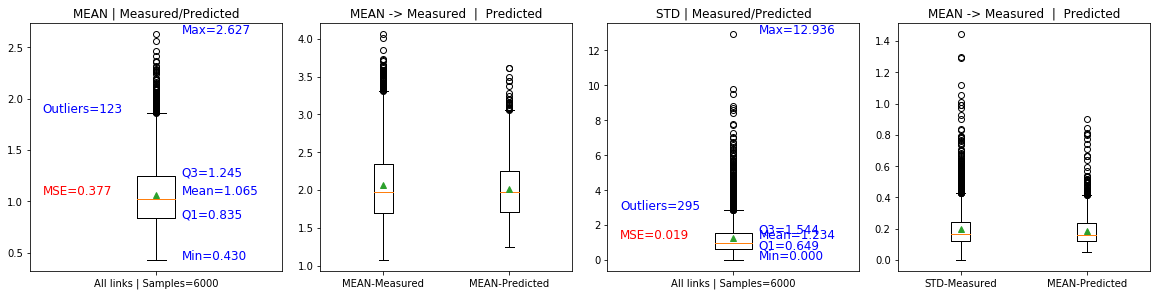

In [5]:
n_samples = 300
n_iter = 20
y_train = X_Train[['time_link_mean']]
x_train = X_Train[['link', 'time_link_std', 'day_minute']]             
x_test = X_Test[['link', 'time_link_std', 'day_minute']]             
y_test = X_Test[['time_link_mean']]

model_grnn = algorithms.GRNN(std=0.1, verbose=False)
model_grnn.fit(x_train, y_train)

y_predicted_mean = []
for iter in range(0, n_iter):
    start_row = n_samples*iter
    end_row = n_samples*(iter+1)
    y_predicted_mean.append(model_grnn.predict(x_test[start_row:end_row]))

error = mean_squared_error(np.array(y_test[0:n_samples*n_iter]), np.reshape(y_predicted_mean,-1,1))
accuracy = np.array(y_test[0:n_samples*n_iter]).T/np.reshape(y_predicted_mean,-1,1)

Q1 = np.quantile(accuracy, 0.25)
Q3 = np.quantile(accuracy, 0.75)
IQR = Q3 - Q1
outliers = ((accuracy < (Q1 - 1.5 * IQR)) | (accuracy > (Q3 + 1.5 * IQR))).sum()
print('Target: MEAN all Links | Samples: ' + str(n_samples*n_iter) + '. MSE: %.5f' % error + ' outliers: ' + str(outliers))

fig, (ax, ax2, ax1, ax3) = plt.subplots(ncols=4, constrained_layout=True, figsize=(16,4))

ax.boxplot(accuracy.T, showmeans=True)
ax.set_title('MEAN | Measured/Predicted')
if outliers != 0:
    ax.text(.55, Q3 + 1.5 * IQR, "Outliers="+str(outliers), size=12, color='blue')
ax.text(.55, np.mean(accuracy), "MSE="+str('%.3f' % error), size=12, color='red')
ax.text(1.1, np.max(accuracy), "Max="+str('%.3f' % np.max(accuracy)), size=12, color='blue')
ax.text(1.1, np.min(accuracy), "Min="+str('%.3f' % np.min(accuracy)), size=12, color='blue')
ax.text(1.1, Q1, "Q1="+str('%.3f' %  Q1), size=12, color='blue')
ax.text(1.1, Q3, "Q3="+str('%.3f' % Q3), size=12, color='blue')
ax.text(1.1, np.mean(accuracy), "Mean="+str('%.3f' % np.mean(accuracy)), size=12, color='blue')
ax.set_xticklabels(['All links | Samples=' + str(n_samples*n_iter)])

data_to_plot = [y_test[:n_samples*n_iter].values[:,0],np.reshape(y_predicted_mean,-1,1)]
ax2.boxplot(data_to_plot, showmeans=True)
ax2.set_title('MEAN -> Measured  |  Predicted')
ax2.set_xticklabels(labels=['MEAN-Measured', 'MEAN-Predicted'])

y_train = X_Train[['time_link_std']]
x_train = X_Train[['link', 'time_link_mean', 'day_minute']]
x_test = X_Test[['link', 'time_link_mean', 'day_minute']]             
y_test = X_Test[['time_link_std']]

model_grnn = algorithms.GRNN(std=0.1, verbose=False)
model_grnn.fit(x_train, y_train)

y_predicted_std = []
for iter in range(0, n_iter):
    start_row = n_samples*iter
    end_row = n_samples*(iter+1)
    y_predicted_std.append(model_grnn.predict(x_test[start_row:end_row]))
    
error = mean_squared_error(np.array(y_test[0:n_samples*n_iter]), np.reshape(y_predicted_std,-1,1))
accuracy = np.array(y_test[0:n_samples*n_iter]).T/np.reshape(y_predicted_std,-1,1)

Q1 = np.quantile(accuracy, 0.25)
Q3 = np.quantile(accuracy, 0.75)
IQR = Q3 - Q1
outliers = ((accuracy < (Q1 - 1.5 * IQR)) | (accuracy > (Q3 + 1.5 * IQR))).sum()
print('Target: STD all Links | Samples: ' + str(n_samples*n_iter) + '. MSE: %.5f' % error + ' outliers: ' + str(outliers))

ax1.boxplot(accuracy.T, showmeans=True)
ax1.set_title('STD | Measured/Predicted')
if outliers != 0:
    ax1.text(.55, Q3 + 1.5 * IQR, "Outliers="+str(outliers), size=12, color='blue')
ax1.text(.55, np.mean(accuracy), "MSE="+str('%.3f' % error), size=12, color='red')
ax1.text(1.1, np.max(accuracy), "Max="+str('%.3f' % np.max(accuracy)), size=12, color='blue')
ax1.text(1.1, np.min(accuracy), "Min="+str('%.3f' % np.min(accuracy)), size=12, color='blue')
ax1.text(1.1, Q1, "Q1="+str('%.3f' %  Q1), size=12, color='blue')
ax1.text(1.1, Q3, "Q3="+str('%.3f' % Q3), size=12, color='blue')
ax1.text(1.1, np.mean(accuracy), "Mean="+str('%.3f' % np.mean(accuracy)), size=12, color='blue')
ax1.set_xticklabels(['All links | Samples=' + str(n_samples*n_iter)])

data_to_plot = [y_test[:n_samples*n_iter].values[:,0],np.reshape(y_predicted_std,-1,1)]
ax3.boxplot(data_to_plot, showmeans=True)
ax3.set_title('MEAN -> Measured  |  Predicted')
ax3.set_xticklabels(labels=['STD-Measured', 'MEAN-Predicted'])

In [ ]:
n_samples = 3000
n_iter = 10
y_train = X_Train[['time_link_mean']]
x_train = X_Train[['link', 'time_link_std', 'day_minute']]             
x_test = X_Test[['link', 'time_link_std', 'day_minute']]             
y_test = X_Test[['time_link_mean']]

model_grnn = algorithms.GRNN(std=0.1, verbose=False)
model_grnn.fit(x_train, y_train)

y_predicted_mean = []
for iter in range(0, n_iter):
    start_row = n_samples*iter
    end_row = n_samples*(iter+1)
    y_predicted_mean.append(model_grnn.predict(x_test[start_row:end_row]))

error = mean_squared_error(np.array(y_test[0:n_samples*n_iter]), np.reshape(y_predicted_mean,-1,1))
accuracy = np.array(y_test[0:n_samples*n_iter]).T/np.reshape(y_predicted_mean,-1,1)

Q1 = np.quantile(accuracy, 0.25)
Q3 = np.quantile(accuracy, 0.75)
IQR = Q3 - Q1
outliers = ((accuracy < (Q1 - 1.5 * IQR)) | (accuracy > (Q3 + 1.5 * IQR))).sum()
print('Target: MEAN all Links | Samples: ' + str(n_samples*n_iter) + '. MSE: %.5f' % error + ' outliers: ' + str(outliers))

fig, (ax, ax2, ax1, ax3) = plt.subplots(ncols=4, constrained_layout=True, figsize=(16,4))

ax.boxplot(accuracy.T, showmeans=True)
ax.set_title('MEAN | Measured/Predicted')
if outliers != 0:
    ax.text(.55, Q3 + 1.5 * IQR, "Outliers="+str(outliers), size=12, color='blue')
ax.text(.55, np.mean(accuracy), "MSE="+str('%.3f' % error), size=12, color='red')
ax.text(1.1, np.max(accuracy), "Max="+str('%.3f' % np.max(accuracy)), size=12, color='blue')
ax.text(1.1, np.min(accuracy), "Min="+str('%.3f' % np.min(accuracy)), size=12, color='blue')
ax.text(1.1, Q1, "Q1="+str('%.3f' %  Q1), size=12, color='blue')
ax.text(1.1, Q3, "Q3="+str('%.3f' % Q3), size=12, color='blue')
ax.text(1.1, np.mean(accuracy), "Mean="+str('%.3f' % np.mean(accuracy)), size=12, color='blue')
ax.set_xticklabels(['All links | Samples=' + str(n_samples*n_iter)])

data_to_plot = [y_test[:n_samples*n_iter].values[:,0],np.reshape(y_predicted_mean,-1,1)]
ax2.boxplot(data_to_plot, showmeans=True)
ax2.set_title('MEAN -> Measured  |  Predicted')
ax2.set_xticklabels(labels=['MEAN-Measured', 'MEAN-Predicted'])

y_train = X_Train[['time_link_std']]
x_train = X_Train[['link', 'time_link_mean', 'day_minute']]
x_test = X_Test[['link', 'time_link_mean', 'day_minute']]             
y_test = X_Test[['time_link_std']]

model_grnn = algorithms.GRNN(std=0.1, verbose=False)
model_grnn.fit(x_train, y_train)

y_predicted_std = []
for iter in range(0, n_iter):
    start_row = n_samples*iter
    end_row = n_samples*(iter+1)
    y_predicted_std.append(model_grnn.predict(x_test[start_row:end_row]))
    
error = mean_squared_error(np.array(y_test[0:n_samples*n_iter]), np.reshape(y_predicted_std,-1,1))
accuracy = np.array(y_test[0:n_samples*n_iter]).T/np.reshape(y_predicted_std,-1,1)

Q1 = np.quantile(accuracy, 0.25)
Q3 = np.quantile(accuracy, 0.75)
IQR = Q3 - Q1
outliers = ((accuracy < (Q1 - 1.5 * IQR)) | (accuracy > (Q3 + 1.5 * IQR))).sum()
print('Target: STD all Links | Samples: ' + str(n_samples*n_iter) + '. MSE: %.5f' % error + ' outliers: ' + str(outliers))

ax1.boxplot(accuracy.T, showmeans=True)
ax1.set_title('STD | Measured/Predicted')
if outliers != 0:
    ax1.text(.55, Q3 + 1.5 * IQR, "Outliers="+str(outliers), size=12, color='blue')
ax1.text(.55, np.mean(accuracy), "MSE="+str('%.3f' % error), size=12, color='red')
ax1.text(1.1, np.max(accuracy), "Max="+str('%.3f' % np.max(accuracy)), size=12, color='blue')
ax1.text(1.1, np.min(accuracy), "Min="+str('%.3f' % np.min(accuracy)), size=12, color='blue')
ax1.text(1.1, Q1, "Q1="+str('%.3f' %  Q1), size=12, color='blue')
ax1.text(1.1, Q3, "Q3="+str('%.3f' % Q3), size=12, color='blue')
ax1.text(1.1, np.mean(accuracy), "Mean="+str('%.3f' % np.mean(accuracy)), size=12, color='blue')
ax1.set_xticklabels(['All links | Samples=' + str(n_samples*n_iter)])

data_to_plot = [y_test[:n_samples*n_iter].values[:,0],np.reshape(y_predicted_std,-1,1)]
ax3.boxplot(data_to_plot, showmeans=True)
ax3.set_title('MEAN -> Measured  |  Predicted')
ax3.set_xticklabels(labels=['STD-Measured', 'MEAN-Predicted'])

Target: MEAN all Links | Samples: 30000. MSE: 0.83636 outliers: 933
